In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as ss

# Para evitar a confusão da aula passada, colocando alguns defaults!
plt.rcParams['figure.figsize']  = (18, 10)
plt.rcParams['axes.labelsize']  = 20
plt.rcParams['axes.titlesize']  = 20
plt.rcParams['legend.fontsize'] = 20
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['lines.linewidth'] = 4

In [2]:
plt.ion()

plt.style.use('seaborn-colorblind')
plt.rcParams['figure.figsize']  = (12, 8)

In [3]:
def despine(ax=None):
    if ax is None:
        ax = plt.gca()
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

In [4]:
np.random.seed(98)

# Aula 07 - Risco

Vamos iniciar esta aula com um conjunto de dados sintéticos. Os mesmos vão ser compostos de uma amostra de uma distribuição Normal. Para fazer tal amostra, use a biblioteca `numpy.random`. Abaixo, nossos dados são gerados a partir de uma distribuição Beta.

In [25]:
data = np.random.beta(3, 2, size=50)
data

array([0.52160756, 0.71579749, 0.32808402, 0.85879682, 0.7790627 ,
       0.88291028, 0.29733962, 0.90724281, 0.89205505, 0.30792483,
       0.52674236, 0.69973727, 0.366497  , 0.89911652, 0.90288469,
       0.60834157, 0.51376794, 0.47259658, 0.45043302, 0.38492154,
       0.21936532, 0.65855484, 0.68754534, 0.82245645, 0.43937706,
       0.65061682, 0.60940463, 0.60011165, 0.81648986, 0.33505094,
       0.42844202, 0.46905752, 0.66235158, 0.72077825, 0.92108056,
       0.83339513, 0.31034896, 0.36755792, 0.89980043, 0.60549403,
       0.73355615, 0.27981509, 0.62604506, 0.5924635 , 0.71672139,
       0.46975397, 0.56408298, 0.65706495, 0.21622344, 0.30666717])

Agora, vamos visualizar os dados. Observe alguns pontos:

1. Dos dados apenas não sabemos a distribuição.
1. Parece um pouco com uma coisa multimodal, mas não é.
1. Sabemos que não é! Pois geramos uma beta.

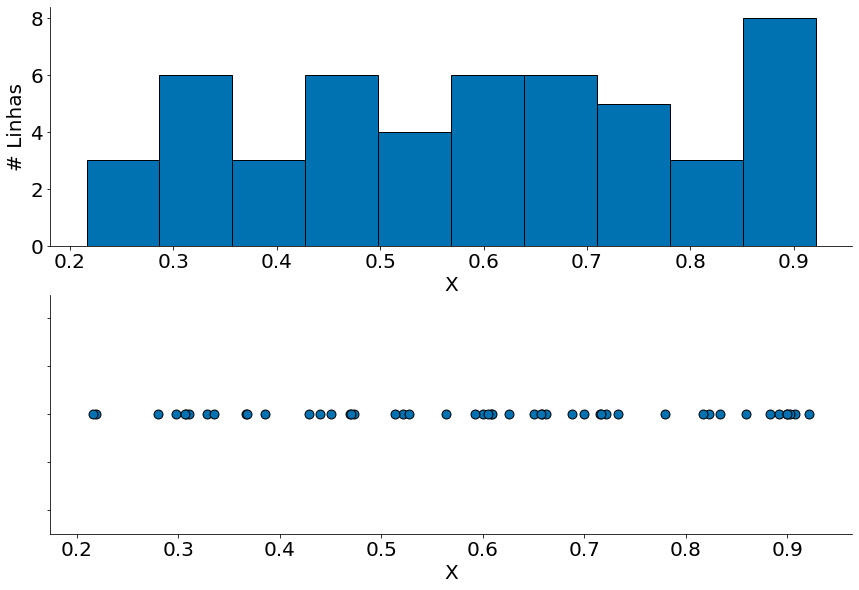

In [26]:
plt.subplot(2, 1, 1)
plt.hist(data, edgecolor='k');
plt.ylabel('# Linhas')
plt.xlabel('X')
despine()

plt.subplot(2, 1, 2)
plt.scatter(data, np.ones(len(data)), s=80, edgecolor='k')
ax = plt.gca()
ax.set_yticklabels([])
plt.xlabel('X')
despine()

plt.tight_layout(pad=0)

### Lei dos Grandes Números

**Do Wikipedia:** A lei dos grandes números (LGN) é um teorema fundamental da teoria da probabilidade, que descreve o resultado da realização da mesma experiência repetidas vezes. De acordo com a LGN, a média aritmética dos resultados da realização da mesma experiência repetidas vezes tende a se aproximar do valor esperado à medida que mais tentativas se sucederem. Em outras palavras, quanto mais tentativas são realizadas, mais a probabilidade da média aritmética dos resultados observados irá se aproximar da probabilidade real.

A prova da lei dos grandes números requer um conhecimento da [Desigualdade de Chebyshev](https://en.wikipedia.org/wiki/Chebyshev%27s_inequality). Não vamos provar no curso. Os que fizerem probabilidade devem conhecer a prova. Caso não tenha feito, não se preocupe, não vamos precisar fazer a prova na mão. Precisamos apenas saber do enunciado:

Considerando $X_1, X_2, \cdots X_n$ uma sequência infinita de variáveis aleatórias i.i.d. com valor esperado $E[X_i]  = E[X_{i-1}]$ = $\mu$. Além do mais, a média amostral de cada VA é: $\overline{X}_n=\frac1n(X_1+\cdots+X_n)$.

A lei dos grandos números fala que:
$$\lim_{n \to \infty} P\left ( \left| \overline{X}_n - \mu \right | < \varepsilon \right ) = 1$$

__Como interpretar a lei:__ Com dados suficientes, a probabilidade de que a média dos meus dados $\overline{X}_n$ se aproxime da média real da população $\mu$ dentro de um fator $\varepsilon>0$ tende para um. Note que $\varepsilon>0$, ou seja, nunca teremos a média real da população. Sempre estamos dentro de erro, pequeno, mas positivo.

Abaixos vamos ver a mesma! Do primeiro plot observe como a média converge com mais amostras.

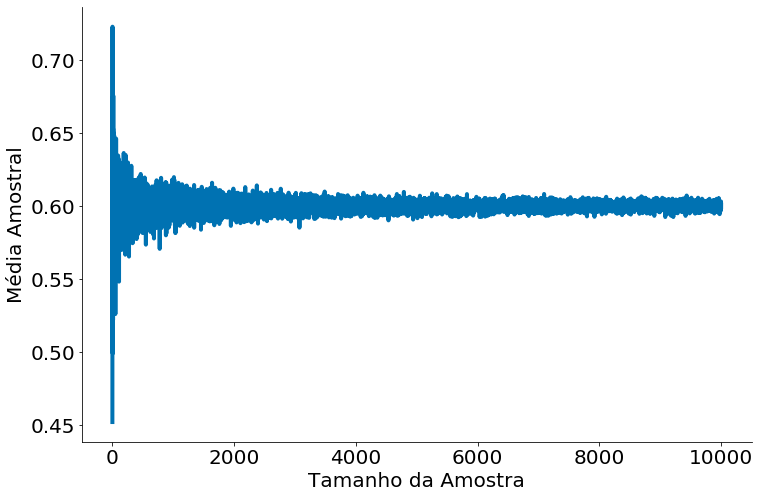

In [27]:
mu = 3 / (3 + 5)
xax = np.arange(2, 10000)
yax = []
diff = []
for size in xax:
    data = np.random.beta(3, 2, size=size)
    yax.append(data.mean())
    diff.append((mu - data.mean())**2) # Diferença ao quadrado
plt.plot(xax, yax)
plt.ylabel('Média Amostral')
plt.xlabel('Tamanho da Amostra')
despine()

Abaixo temos o erro ao quadrado. Note que nunca é zero. A lei não fala isto, fala que a distância fica dentro de um epsilon. A lei dos grandes números não fala em erro ao quadrado, foi feito aqui pois liga com a definição de Risco de um estimador (mais na frente).

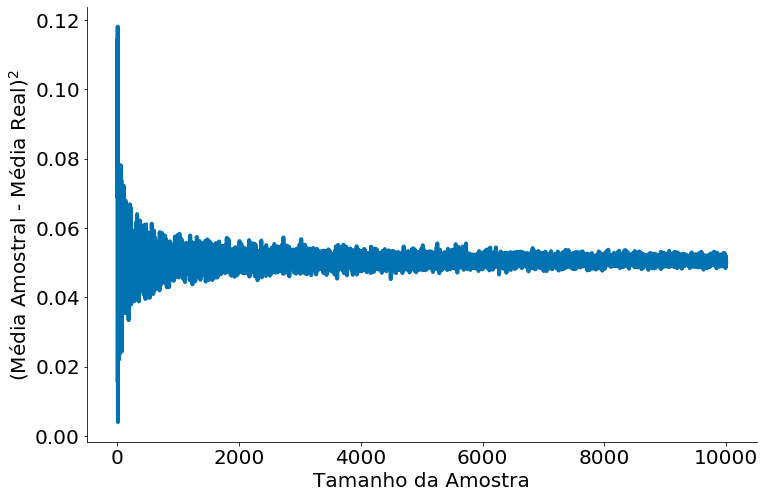

In [8]:
plt.plot(xax, diff)
plt.ylabel('(Média Amostral - Média Real)$^2$')
plt.xlabel('Tamanho da Amostra')
despine()

### Valor Esperado do Estimador

Observe que nosso ponto de partida foi uma única amostra. Para amostras diferentes da mesma população nosso estimador pode ser comportar diferente. Como podemos entender tal efeito? Simples, vamos gerar várias amostras! Para cada uma, temos um estimador diferente. 

**Notação:** $X_1, X_2, X_3, X_4, \cdots, X_n \sim Beta(3, 2)$

Por clareza, vamos assumir que cada amostra tem um tamanho igual (e.g., 50). Podemos então entender cada amostra como sendo gerado de uma mesma variável aleatória (a beta). O sinal $\sim$ significa amostre dados. Assim, cada amostra é independente e distribuída de forma identica (todas são geradas de uma Beta(3, 2)).

Abaixo mostro o histograma de 1000 estimadores da média amostral. Como que chegamos no gráfico?
1. Gere $X_1, X_2, X_3, X_4, \cdots, X_{100}$
1. Compute a média de cada $X_i$
1. Plote

### Um estimador Bom

In [33]:
estimativas = []
for _ in range(1000):
    data = np.random.beta(3, 2, size=50)
    estimativas.append(data.mean())

Com tais amostras podemos explorar os conceitos de viés e variancia de um estimador. Note que não estamos falando dos dados, sim dos valores estimados. A intuição aqui é que: Cada amostra de dados leva para uma estimativa diferente. Quão próximo serão tais estimativas de um valor real? Como tais estimativas variam?

No gráfico abaixo é possível ver que o estimador fica em torno do valor real $\mu = 0.6$.

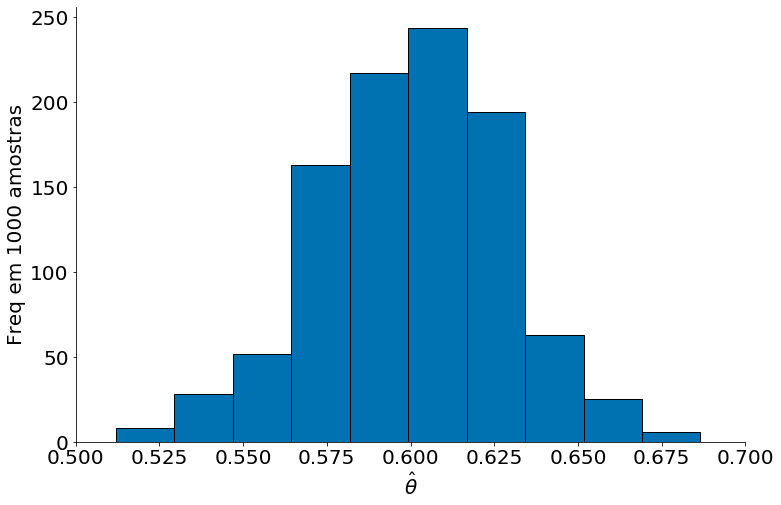

In [34]:
plt.hist(estimativas, edgecolor='k');
plt.xlabel(r'$\hat{\theta}$')
plt.ylabel('Freq em 1000 amostras')
plt.xlim(.5, .7)
despine()

Agora vamos fazer um estimador com amostras de tamanho 10000. Observe como estamos mais perto do valor real. É esperado, pela lei dos grandes números, quanto maior a quantidade de dados mais perto ficamos.

In [37]:
estimativas = []
for _ in range(1000):
    data = np.random.beta(3, 2, size=30)
    estimativas.append(data.mean())

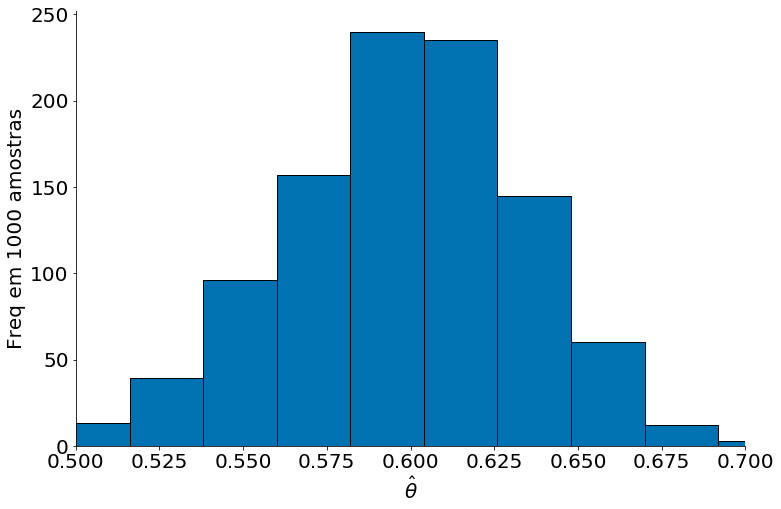

In [38]:
plt.hist(estimativas, edgecolor='k');
plt.xlabel(r'$\hat{\theta}$')
plt.ylabel('Freq em 1000 amostras')
plt.xlim(.5, .7)
despine()

O primeiro gráfico acima tem um viés baixo e variância alta. Note como o plot é mais disperso do que o segundo. Tal segundo, em contrapartida, tem variância baixa. Este é um efeito de aumentar o número de pontos. Vamos explorar um pouco mais tal efeito agora.

### (Detour) Um estimador Ruim

Em suma, os dois plots giram em torno do valor real, ou seja, não são viesados. Parece óbvio pois você já sabe que a média da amostra é um bom estimador da média da população. Isto foi definido na lei dos grandes números acima.

De qualquer forma, nada impede uma estimativa de outros estimadores tolos. Abaixo temos o estimador $\hat{\theta_b}$. O mesmo é a média geométrica de três pontos. Observe como o estimador é viesado!

$\hat{\theta_b} = \sqrt{X_1 * X_2 * X_3}$

In [44]:
estimativas = []
for _ in range(1000):
    data = np.random.beta(3, 2, size=300)
    estimativas.append(np.sqrt(data.prod()))

Note que o mesmo tem alto viés e alta variância.

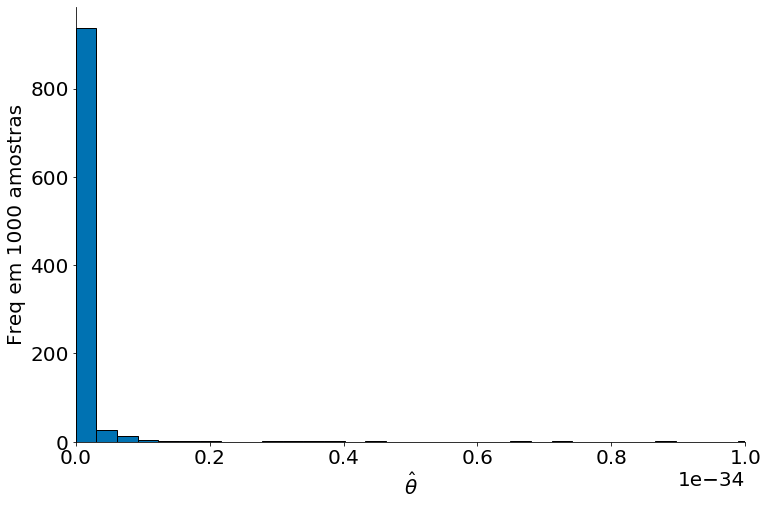

In [50]:
plt.hist(estimativas, edgecolor='k', bins=200);
plt.xlabel(r'$\hat{\theta}$')
plt.ylabel('Freq em 1000 amostras')
plt.xlim(0, 1e-34)
despine()

## Caracterizando um Estimador

Lembre-se de nossas suposições até agora: assumimos que existe um valor real da população. Tal valor é a nossa média $\mu = 0.6$. Podemos chamar tal média de nosso objetivo $\theta^{*} = \mu$. Nosso modelo estima esse parâmetro. Para tal, usamos a variável $\hat{\theta}$ para denotar nossa estimativa. Gostaríamos de usar os dados coletados para determinar o valor que $\hat{\theta}$ deveria ter.

### Uma Função de Perda

Para decidir com precisão qual é o melhor valor de $\hat{\theta}$, definimos uma função de perda. Uma função de perda é uma função matemática que leva em uma estimativa $\hat{\theta}$ e os pontos em nosso conjunto de dados. Tal função tem uma única resposta real $L(\hat{\theta}) \in \mathbb{R}$. Quão menor esse valor, melhor é a nossa estimativa.

Algumas funções de perda são:

$$L(\hat{\theta}) = \frac{1}{n}\sum_{i=1}^{n} (\hat{\theta} - x_i)^2$$

e 

$$L(\hat{\theta}) = \frac{1}{n}\sum_{i=1}^{n} |\hat{\theta} - x_i|$$

A primeira define um erro quadrado médio. A segunda define o erro absoluto médio. Vamos entender as duas:

In [15]:
def mse(theta, data):
    return ((data - theta) ** 2).mean()

In [16]:
def mae(theta, data):
    return np.abs(data - theta).mean()

In [17]:
data = np.random.beta(3, 2, size=50)

Observe como o MSE, erro quadrado médio, tem valor mínimo na média 0.6.

Text(0.5, 0, '$\\hat{\\theta}$')

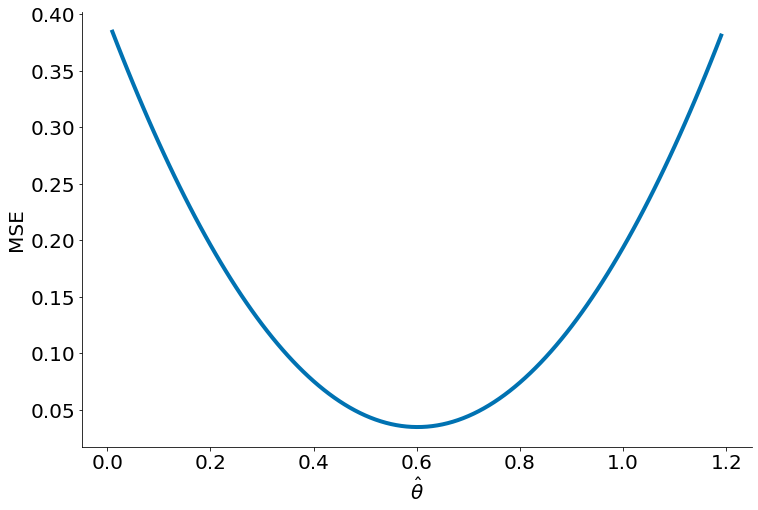

In [18]:
xax = np.arange(0.01, 1.2, 0.01)
yax = []
for theta in xax:
    yax.append(mse(theta, data))
plt.plot(xax, yax)
despine()
plt.ylabel('MSE')
plt.xlabel(r'$\hat{\theta}$')

**Valor ótimo do MSE** Podemos provar que o MSE retorna a média. Para isto, basta derivar a função e igualar a derivada a zero.

\begin{align}
L(\hat{\theta}) = \frac{1}{n}\sum_{i=1}^{n} (\hat{\theta} - x_i)^2 \\
\end{align}

Vamos derivar. Podemos fazer uso da regra da cadeia ou usar a expansão da forma quadrática. Vou seguir a segunda linha para ser mais explícito.

\begin{align}
L(\hat{\theta}) = \frac{1}{n}\sum_{i=1}^{n} \hat{\theta}^2 - 2\theta x_i + x_i^2 \\
{\delta L \over \delta\hat{\theta}} = \frac{1}{n}\sum_{i=1}^{n} \hat{2\theta} - 2x_i
\end{align}

Agora podemos igualar para zero.

\begin{align}
{\delta L \over \delta\theta} = \sum_{i=1}^{n} \hat{2\theta} - 2x_i \\
\sum_{i=1}^{n} \hat{2\theta} - 2x_i  = 0 \\
\sum_{i=1}^{n} \hat{2\theta} = \sum_{i=1}^{n} 2x_i \\
2 n \hat{\theta} = 2 \sum_{i=1}^{n} x_i \\
\hat{\theta} = n^{-1} \sum_{i=1}^{n} x_i = \bar{x}
\end{align}

*Assim, um estimador de MSE retorna a média, sempre.*

**MAE, mean absolute error, ou erro médio absoluto** 

O mesmo não é verdade para o MAE. Primeiro, observe a forma da função abaixo. O valor ótimo, menor, não é mais a média.

Text(0.5, 0, '$\\hat{\\theta}$')

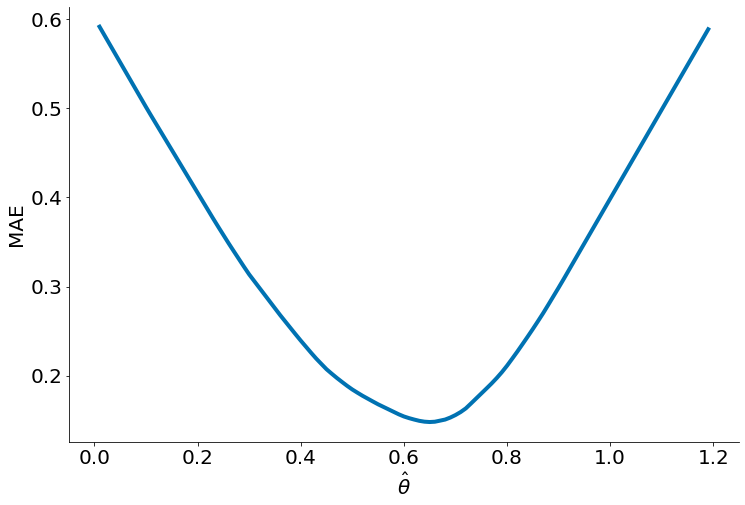

In [19]:
xax = np.arange(0.01, 1.2, 0.01)
yax = []
for theta in xax:
    yax.append(mae(theta, data))
plt.plot(xax, yax)
despine()
plt.ylabel('MAE')
plt.xlabel(r'$\hat{\theta}$')

Podemos mostrar que ao mimizar o MAE, retornamos a mediana:

\begin{align}
L(\hat{\theta}) = n^{-1}\sum_{i=1}^{n} |\hat{\theta} - x_i| \\
\text{Vamos derivar. Faça uso de:} \\
\frac{\delta |x|}{\delta x} = sign(x)
\end{align}

Sign indica o sinal de x. Por exemplo: Sign(-20) = -1. Sign(99) = 1. Sign(0) = 0.

Primeiro vamos quebrar a expressão em três. (1) Valores menores do que theta; (2) Valores maiores; e, (3) Valores iguais. Além do mais, vamos assumir que a derivada da função absoluta existe em zero. Além de assumir que existe, assumimos que a mesma é igual a zero.

\begin{aligned} L(\hat{\theta}) &=\sum_{i=1}^{n}\left|\hat{\theta}-x_{i}\right| \\ &=\sum_{\theta<x_i}\left|\hat{\theta}-x_{i}\right|+\sum_{\hat{\theta}=x_{i}}\left|\hat{\theta}-x_{i}\right|+\sum_{\hat{\theta}> x_i}|\hat{\theta}-x_i| \end{aligned}

Derivando ficamos com três partes. Lembre-se que a derivada da função absoluto é apenas o sinal (acima).

\begin{aligned} {\delta L \over \delta \hat{\theta}} = \sum_{\theta<x_i}-1+\sum_{\hat{\theta}=x_{i}}0+\sum_{\hat{\theta}> x_i}1
\end{aligned}

Igualando com zero chegamos em uma expressão esquisita.

$$\sum_{\theta<x_i}1 =\sum_{\hat{\theta}> x_i}1$$

Como interpretar a mesma? Observe que de um lado contamos os números negativos. Do outro, os positivos. O valor ótimo tem contagens iguais dos dois lados. Que número mágico separa métade dos valores de um lado e metade dos outros? A mediana!

*Ao minimizar o MAE ficamos com a mediana!*

## Risco


O risco de um estimador é o valor esperado da perda do modelo em pontos escolhidos aleatoriamente. No nosso cenário, a população consiste de uma distribuição Beta. Usamos a variável aleatória $X$ para representar uma amostra: $X \sim Beta(3, 2)$. O risco então visa responder, qual a média do erro para tal amostra? Vamos definir o risco usando MSE.

Usando nossa notação, o risco $R(\hat{\theta})$ do nosso estimador é:

$$R(\hat{\theta}) = \mathbb{E}[(X - \hat{\theta})^2]$$

Na expressão acima, usamos a perda MSE que fornece o erro interno da expectativa. Podemos definir outros riscos, mas esse é bem caracterizado (conseguimos entender o mesmo). O risco é uma função de $\hat{\theta}$, pois podemos mudar $\hat{\theta}$ como quisermos.

Diferentemente da perda, o uso do risco nos permite argumentar sobre a precisão do modelo na população em geral. Se nosso modelo atingir um risco baixo, ele fará previsões precisas sobre pontos da população a longo prazo. Por outro lado, se nosso modelo tiver um risco alto, ele geralmente terá um desempenho ruim nos dados da população.

Naturalmente, gostaríamos de escolher o valor de $\hat{\theta}$ que torna o risco o mais baixo possível. Usamos a variável $\theta^{*}$ para representar o valor ótimo. 


Seção sendo escrita. Leia: https://www.textbook.ds100.org/ch/12/prob_risk.html. Use o translate caso necessite!